<a href="https://colab.research.google.com/github/BTExpress1/relax/blob/main/Relax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import io
import requests
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_recall_curve, average_precision_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [2]:
def load_and_group_dataframe(shareable_link):
    """
    Loads a CSV file from a Google Drive shareable link into a pandas DataFrame
    and displays the head of the DataFrame with columns grouped by numerical
    and then non-numerical data types.

    Args:
        shareable_link (str): The "Anyone with the link can view" link to the
                              CSV file on Google Drive.
    """
    file_id = None
    if "/d/" in shareable_link and "/view" in shareable_link:
        file_id = shareable_link.split("/d/")[1].split("/view")[0]
    elif "/file/d/" in shareable_link and "/edit" in shareable_link:
        file_id = shareable_link.split("/file/d/")[1].split("/edit")[0]

    if file_id:
        download_url = f"https://drive.google.com/uc?id={file_id}&export=download"

        try:
            response = requests.get(download_url)
            response.raise_for_status()  # Raise an exception for bad status codes

            # Read the CSV data directly from the response content
            ut_data = pd.read_csv(io.StringIO(response.text))
            print("Data loaded successfully from Google Drive:")

            # Separate numerical and non-numerical columns
            numerical_cols = ut_data.select_dtypes(include=['number']).columns.tolist()
            non_numerical_cols = ut_data.select_dtypes(exclude=['number']).columns.tolist()

            # Create the desired column order
            ordered_cols = numerical_cols + non_numerical_cols

            # Display the DataFrame with the ordered columns (showing the head)
            # print(ut_data[ordered_cols].head())

            return ut_data  # Return the loaded DataFrame

        except requests.exceptions.RequestException as e:
            print(f"Error downloading file from Google Drive: {e}")
            return None
        except pd.errors.EmptyDataError:
            print("Error: The downloaded file appears to be empty.")
            return None
        except Exception as e:
            print(f"An error occurred while processing the downloaded data: {e}")
            return None

    else:
        print("Error: Could not extract file ID from the shareable link. Please ensure the link is correct.")
        return None


In [3]:
def count_users_login_three_days(df):
    """
    Identifies users who logged in on at least three separate days
    within at least one seven-day period and returns a boolean Series.

    Args:
        df (pd.DataFrame): DataFrame with 'user_id' and 'timestamp' columns.

    Returns:
        pd.Series: A boolean Series where index is user_id and True
                   indicates the user met the criteria.
    """
    df['time_stamp'] = pd.to_datetime(df['time_stamp'])
    df = df.sort_values(by=['user_id', 'time_stamp'])

    def check_three_day_login(user_df):
        dates = user_df['time_stamp'].dt.date.unique()
        for i in range(len(dates) - 2):
            week_start = dates[i]
            week_end = week_start + pd.Timedelta(days=6)
            login_within_week = [d for d in dates if week_start <= d <= week_end]
            if len(login_within_week) >= 3:
                return True
        return False

    user_counts = df.groupby('user_id').apply(check_three_day_login)
    return user_counts # Return the entire Series


In [4]:
def get_counted_users_with_names(user_counts_series, names_df):
    """
    Creates a tuple of (user_id, name) for the users counted.

    Args:
        user_counts_series (pd.Series): A boolean Series where index is user_id
                                         and True indicates the user met the criteria.
        names_df (pd.DataFrame): DataFrame with 'user_id' and 'name' columns.

    Returns:
        tuple: A tuple of (user_id, name) for the counted users.
    """
    counted_user_ids = user_counts_series[user_counts_series].index.tolist()
    counted_users_with_names = []
    for user_id in counted_user_ids:
        try:
            user_info = names_df[names_df['user_id'] == user_id]['name'].iloc[0]
            counted_users_with_names.append((user_id, user_info))
        except IndexError:
            print(f"Warning: Name not found for user_id {user_id}")
    return tuple(counted_users_with_names)

In [5]:
shareable_link = "https://drive.google.com/file/d/1mbMcDUYUo6mVA-y7q91oFNLKrcQKwNBq/view?usp=sharing"
th_user = load_and_group_dataframe(shareable_link)

# Work with the DataFrame if it was loaded successfully
if th_user is not None:
    # View the new DataFrame for further analysis or processing
    print("\nDataFrame shape:", th_user.shape)

th_user.head()

Data loaded successfully from Google Drive:

DataFrame shape: (12000, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
shareable_link = "https://drive.google.com/file/d/1PGFGBookcWF4kpTVnZk7nuoDTRJTgXJE/view?usp=sharing"
th_user_egmnt = load_and_group_dataframe(shareable_link)

# Work with the DataFrame if it was loaded successfully
if th_user_egmnt is not None:
    # View the new DataFrame for further analysis or processing
    print("\nDataFrame shape:", th_user_egmnt.shape)

th_user_egmnt.head()

Data loaded successfully from Google Drive:

DataFrame shape: (207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
#Joining the two DataFrames

merged_df = (
    th_user
    .merge(th_user_egmnt, left_on='object_id', right_on='user_id', how='inner')
    .drop('user_id',axis=1)
    .rename(columns={'object_id': 'user_id'})
)

merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   user_id                     207917 non-null  int64  
 1   creation_time               207917 non-null  object 
 2   name                        207917 non-null  object 
 3   email                       207917 non-null  object 
 4   creation_source             207917 non-null  object 
 5   last_session_creation_time  207917 non-null  float64
 6   opted_in_to_mailing_list    207917 non-null  int64  
 7   enabled_for_marketing_drip  207917 non-null  int64  
 8   org_id                      207917 non-null  int64  
 9   invited_by_user_id          116887 non-null  float64
 10  time_stamp                  207917 non-null  object 
 11  visited                     207917 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 19.0+ MB


In [8]:
merged_df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-15 03:45:04,1
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-29 03:45:04,1
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-09 03:45:04,1
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-25 03:45:04,1


In [9]:
merged_df.isnull().sum()

,0
user_id,0
creation_time,0
name,0
email,0
creation_source,0
last_session_creation_time,0
opted_in_to_mailing_list,0
enabled_for_marketing_drip,0
org_id,0
invited_by_user_id,91030


The invinted by column is the only one with null values. I need to determine if it is an important column to impute for the purpose of a model. After, initially dropping it, I changed it to a binary feature with 1 for invited and 0 for not invited.

In [10]:
merged_df_new = merged_df.drop(columns=['invited_by_user_id'])
merged_df_new['was_invited'] = merged_df['invited_by_user_id'].notna().astype(int)

In [11]:
merged_df_new.shape

(207917, 12)

In [12]:
# Adopted user count
num_users_series = count_users_login_three_days(merged_df_new.copy())
total_users = merged_df_new['user_id'].unique().size
num_counted_users = num_users_series.sum() # Calculate the count from the Series
print(f"Number of users with logins on at least three separate days within a 7-day period: {num_counted_users}, {(num_counted_users/total_users*100):.2f}% of {total_users} total users")


Number of users with logins on at least three separate days within a 7-day period: 1602, 18.16% of 8823 total users


<ipython-input-3-965dc6417627>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_counts = df.groupby('user_id').apply(check_three_day_login)


In [13]:
# 'num_users_series' is the Series returned by counting function on merged_df_new
counted_users_tuple = get_counted_users_with_names(num_users_series, merged_df_new)
n_samples = 5
print(f"Sample of the first {n_samples} adopted users:")
for i in range(min(n_samples, len(counted_users_tuple))):
    print(counted_users_tuple[i])

Sample of the first 5 adopted users:
(2, 'Poole Matthew')
(10, 'Santos Carla')
(20, 'Helms Mikayla')
(33, 'Araujo José')
(42, 'Pinto Giovanna')


In [14]:
merged_df_new.columns

Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'time_stamp', 'visited',
       'was_invited'],
      dtype='object')

During the first run of the model, there appeared to be an overfitting with an accuracy of 99% and a perfect recall on class 1. I dropped the last_session_creation_time,name, time_stamp, and email from X to remove noise.

In [15]:
# --- Data Preparation ---

# Based on counted user, build a new boolean feature future_adoipter
adopter_user_ids = set(user_id for user_id, _ in counted_users_tuple)
merged_df_new['future_adopter'] = merged_df_new['user_id'].isin(adopter_user_ids).astype(int)

# Simplify creation_time
merged_df_new['creation_month'] = pd.to_datetime(merged_df_new['creation_time']).dt.to_period('M').astype(str)

y = merged_df_new['future_adopter']
X = merged_df_new.drop(columns=['future_adopter','last_session_creation_time','creation_time','name','time_stamp','email'], errors='ignore')

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing pipeline
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Using ColumnTransformer, combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Split data 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 3. Model Building and Training (Random Forest) ---
# Create the Random Forest model
random_forest_model = RandomForestClassifier(class_weight='balanced',random_state=42) # Setting random_state for reproducibility

# Create the full pipeline: preprocessing + model
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', random_forest_model)])

rf_pipeline.fit(X_train,y_train)

# --- Model Prediction ---
y_pred = rf_pipeline.predict(X_test)
# Get predicted probabilities
y_pred_proba = rf_pipeline.predict_proba(X_test)[:, 1]


Confusion Matrix:
 [[ 1792   208]
 [    0 39584]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95      2000
           1       0.99      1.00      1.00     39584

    accuracy                           0.99     41584
   macro avg       1.00      0.95      0.97     41584
weighted avg       1.00      0.99      0.99     41584

Accuracy Score: 0.9949980761831474
ROC AUC Score: 0.9999922948666128
F1 Score: 0.9973795605724652 




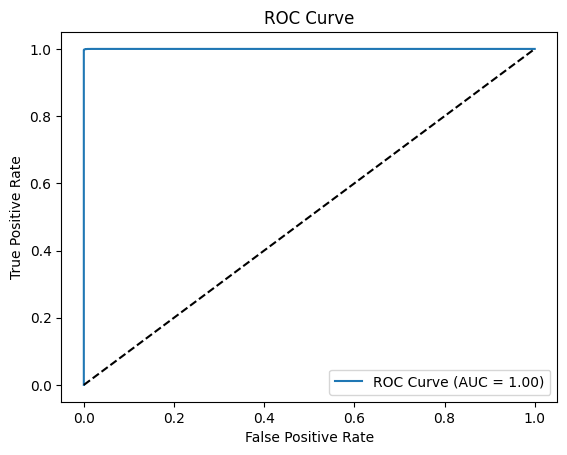

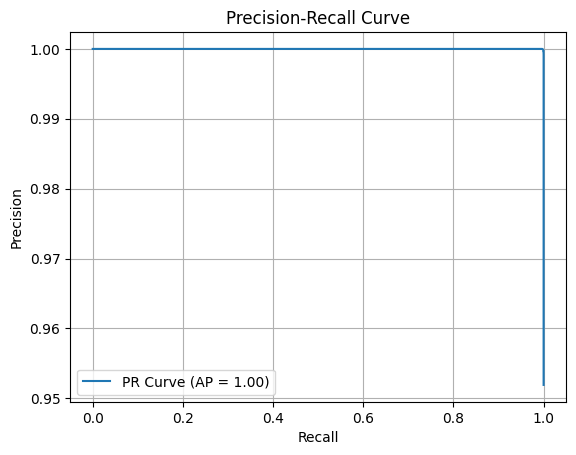

In [19]:
# --- Model Evaluation ---

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# F1 Score
print("F1 Score:", f1_score(y_test, y_pred),'\n\n')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print(f"\n\n")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure()
plt.plot(recall, precision, label=f'PR Curve (AP = {avg_precision:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# Access the trained classifier step
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=X_train.columns)
importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Feature Importance
feature_importances = pd.Series(importances, index=feature_names)


In [17]:
feature_importances.head(20)

,0
num__user_id,0.304072
num__opted_in_to_mailing_list,0.024916
num__enabled_for_marketing_drip,0.019055
num__org_id,0.301243
num__visited,0.000000
num__was_invited,0.008615
cat__creation_source_GUEST_INVITE,0.008629
cat__creation_source_ORG_INVITE,0.009719
cat__creation_source_PERSONAL_PROJECTS,0.008218
cat__creation_source_SIGNUP,0.009255


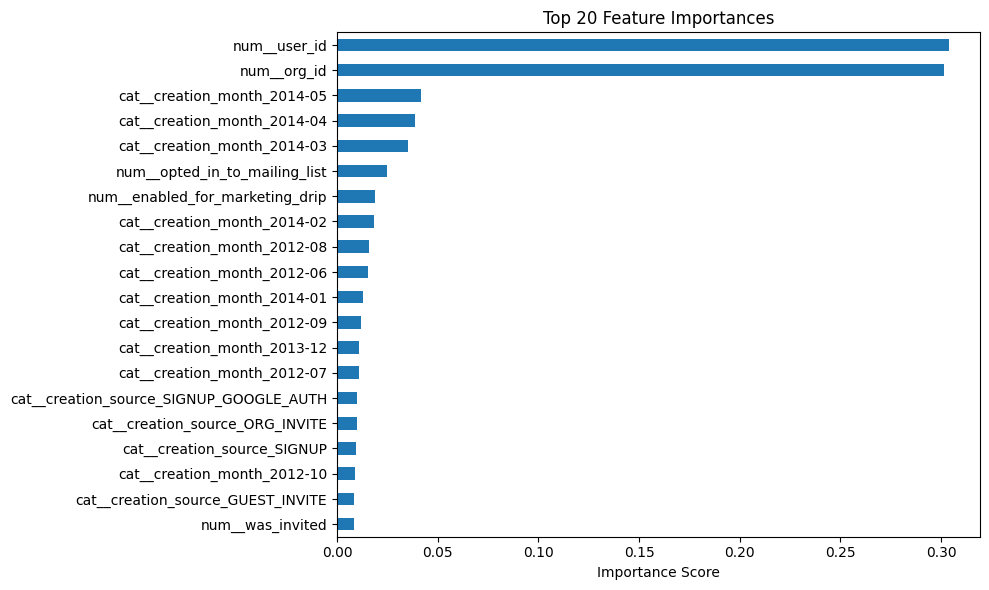

In [24]:
# Plot top 20
top_n = 20
top_features = feature_importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()




In [30]:
# Save pipeline
filename = 'rf_pipeline_model.pkl'
joblib.dump(rf_pipeline, filename)

# Confirm save
if os.path.exists(filename):
    print('Pipeline saved successfully')
else:
    print('Pipeline save failed')

Pipeline saved successfully
